In [1]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import normalize

In [2]:
from carp.configs import CARPConfig
from carp.pytorch.model.architectures import *
from carp.pytorch.data import *

# Load model
config = CARPConfig.load_yaml("carp_cloob.yml")
cloob_model = CARPCloob(config.model)
cloob_model.load("CLOOB_CP/")
cloob_model = cloob_model.cuda()

# Load data
pipeline = BaseDataPipeline(path="../carp/dataset")
passages = pipeline.passages
reviews = pipeline.reviews
N = len(passages)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaMod

In [3]:
# Sample random batch from dataset
def get_random_batch(size):
    inds = torch.randint(0, N, (size,))
    p = [passages[ind][:512] for ind in inds]
    r = [reviews[ind][:512] for ind in inds]

    return p, r

# Use tokenizer on a batch of passages and reviews
def tokenizer_batch(p,  r):
    p_tok = cloob_model.passage_encoder.call_tokenizer(p)
    r_tok = cloob_model.passage_encoder.call_tokenizer(p)
    return p_tok, r_tok

# construct batch element from a tokenizer output
def make_batch_elem(tok_out):
    return BatchElement(tok_out['input_ids'],
                       tok_out['attention_mask'])

# Sample random batch from dataset and encode it
def encode_rand_batch(size):
    p_batch_s, r_batch_s = get_random_batch(size)
    p_tok, r_tok = tokenizer_batch(p_batch_s, r_batch_s)
    p_batch = make_batch_elem(p_tok)
    r_batch = make_batch_elem(r_tok)

    with torch.no_grad():
        pass_encs, rev_encs = \
                cloob_model.calculate_embeddings([p_batch], [r_batch])
    # -> [[pass_encs], [rev_encs]]
    pass_encs = pass_encs[0].float()
    rev_encs = rev_encs[0].float()
    
    pass_encs = normalize(pass_encs)
    rev_encs = normalize(rev_encs)

    return (pass_encs, p_batch_s), \
        (rev_encs, r_batch_s)

# Given encodings and batch (strings), return PCA result
# and batch sorted by first value in PCA vectors
def pca_sort(encs, batch):
    U,_,_ = torch.pca_lowrank(encs, q = 2)
    U = U.detach().cpu().numpy()

    # Sort by x value for easier visualization
    U = [[u, pass_] for (u, pass_) in zip(U, batch)]
    U = sorted(U, key = lambda x: x[0][0])
    batch = [x[1] for x in U]

    # Get 2d vectors from PCA
    U = [x[0] for x in U]

    return U, batch

# PCA Scatter Plot

“How long have you known about shifters?” : [-0.44935584  0.34426045]
I squeezed hard against myself until I could finally feel that I had wet myself. : [-0.40150386  0.14342217]
Whether finally obeying her command or from sheer exhaustion, John0 released his death-grip from Sam0's neck. His head slammed against the ground and his body skidded to a stop. : [-0.2823679  -0.27076918]
Life is one eternal round. For every beginning there is an end and for every ending there is a new beginning. SFG 3/23/2019 : [-0.2718608  -0.10658294]
“We make the conscious decision whether or not to commit a crime. Everyone plays their cards.” And there’s only four aces in the deck.” : [-0.08532043 -0.04883365]
Jane0 stepped over a ham bone and bit her lip to keep from commenting. : [-0.05376008 -0.5780678 ]
Amused by his discomfort, Seraphima smiled, feeling a confidence she hadn’t had before. “Come out with it, Sam1 She gestured toward her feet. “As you can see, we’re in the middle of skating through th

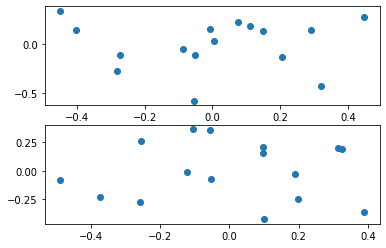

In [65]:
(pass_encs, pass_batch), (rev_encs, rev_batch) = encode_rand_batch(16)

U_p, pass_batch = pca_sort(pass_encs, pass_batch)
U_r, rev_batch = pca_sort(rev_encs, rev_batch)

fig, axs = plt.subplots(2)

# Print all values
for i, pass_ in enumerate(pass_batch):
    print("=========================")
    print(pass_ + " : " + str(U_p[i]))

for i, rev_ in enumerate(rev_batch):
    print("=========================")
    print(rev_ + " : " + str(U_r[i]))

# Plots
U_x = [np.array([u[0] for u in U]) for U in [U_p, U_r]]
U_y = [np.array([u[1] for u in U]) for U in [U_p, U_r]]
       
axs[0].scatter(U_x[0], U_y[0])
axs[1].scatter(U_x[1], U_y[1])

plt.show()

# N-Spherical Coordinate PCA
Model embeddings $x_i$ are by default normalized to be points on a hypersphere ($||x_i||_2 = 1$). As such, any given $x_i \in \mathbb{R^n}$ can be parameterized by $n - 1$ angles $(\phi_{i,1},\ldots,\phi_{i,n-1}) = \phi_i \ \in [0,\pi]^{n-1} \times [-\pi,\pi)$. The formula for deriving $\phi_i$ from $x_i$ is based on [this](https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates), with $r = 1$.

In [68]:
# assume x is normalized (l2 norm x_i = 1)
# assumes d >= 3
def spherical_coord(x):
    n, d = x.shape
    # -> unit n-sphere points

    # phi[:,0:d-2] in [0, pi]
    # phi[:,d-2] in [-pi, pi]
    phi = torch.zeros_like(x)[:,:-1] # -> (n, d-1)

    # value being curried to compute next angle
    curr = x[:,d-1].pow(2) + x[:,d-2].pow(2)
    
    # compute last angle first (it has weird formula conditioned on x_d)
    phi[:,d-2] = torch.acos(x[:,d-2] / curr.sqrt())
    phi[:,d-2] = torch.where(x[:,d-1] >= 0, phi[:,d-2], 2 * np.pi - phi[:,d-2])
    
    # compute the rest
    for i in reversed(range(0, d-2)):
        curr += x[:,i].pow(2)
        phi[:,i] = torch.acos(x[:,i] / curr.sqrt())

    return phi

x = normalize(torch.randn(512, 2048))
y = spherical_coord(x)
print(y.shape)

# If angles are uniformly between 0 and pi on average (excluding the final one)
# We expect mean angle to be pi/2 = ~ 1.57
print(y.mean())

torch.Size([512, 2047])
tensor(1.5713)


John0 was unsure of what to say in response. He was kept from a dangerous task only to be assigned to it now. It took but a moment for John0 to come to the conclusion. He stared at his old friend who appeared more fragile than ever leaning upon the cartography table. Some of that cold frost melted from the uncertainty in Jarod’s eyes. Some design, some conspiracy or machination was at play and his friend, the Emperor Sam1 of the Sam2 Sam3 did not want him around for it's outcome. Did not desire that so stro : [-0.40285754 -0.01375995]
A crease marred the space between his step-mother’s eyebrows. Sam0 why didn’t you wait until we could all attend? Why the rush?” : [-0.39232075 -0.0669024 ]
“Yeah, I know I’m ‘Too Honest’ but it’s true.” : [-0.32947323 -0.30138394]
When he responded, John0's voice poured out of his mouth like honey. “Princess of Sam0 stories of your beauty do not do you justice.” : [-0.19099516 -0.11276398]
Friends and neighbors filed past Aunt TT, pressing condolences in

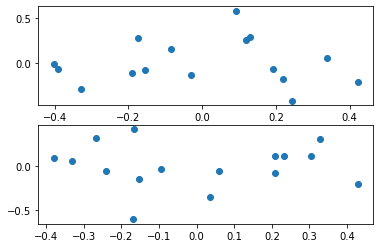

In [69]:
(pass_encs, pass_batch), (rev_encs, rev_batch) = encode_rand_batch(16)

pass_encs = spherical_coord(pass_encs)
rev_encs = spherical_coord(rev_encs)

U_p, pass_batch = pca_sort(pass_encs, pass_batch)
U_r, rev_batch = pca_sort(rev_encs, rev_batch)

fig, axs = plt.subplots(2)

# Print all values
for i, pass_ in enumerate(pass_batch):
    print("=========================")
    print(pass_ + " : " + str(U_p[i]))

for i, rev_ in enumerate(rev_batch):
    print("=========================")
    print(rev_ + " : " + str(U_r[i]))

# Plots
U_x = [np.array([u[0] for u in U]) for U in [U_p, U_r]]
U_y = [np.array([u[1] for u in U]) for U in [U_p, U_r]]
       
axs[0].scatter(U_x[0], U_y[0])
axs[1].scatter(U_x[1], U_y[1])

plt.show()

# Compare Spherical To Normal

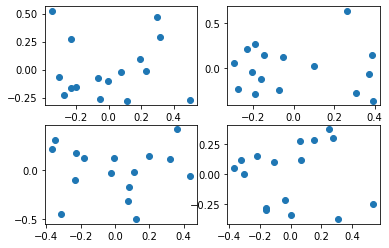

In [70]:
(pass_encs, pass_batch), (rev_encs, rev_batch) = encode_rand_batch(16)

U_p_sphere, pass_batch_sphere = pca_sort(spherical_coord(pass_encs), pass_batch)
U_p, pass_batch = pca_sort(pass_encs, pass_batch)
U_r_sphere, rev_batch_sphere = pca_sort(spherical_coord(rev_encs), rev_batch)
U_r, rev_batch = pca_sort(rev_encs, rev_batch)

U_x = [np.array([u[0] for u in U]) for U in [U_p, U_p_sphere, U_r, U_r_sphere]]
U_y = [np.array([u[1] for u in U]) for U in [U_p, U_p_sphere, U_r, U_r_sphere]]

fig, axs = plt.subplots(2,2)
axs[0,0].scatter(U_x[0], U_y[0])
axs[0,1].scatter(U_x[1], U_y[1])
axs[1,0].scatter(U_x[2], U_y[2])
axs[1,1].scatter(U_x[3], U_y[3])